In [1]:
# ✅ INSTALL REQUIRED LIBRARIES
!pip install xgboost scikit-learn joblib pandas matplotlib shap imbalanced-learn --quiet
!pip install --upgrade xgboost
!apt-get install -y libgomp1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libgomp1 is already the newest version (12.3.0-1ubuntu1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
# ✅ IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import random
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:03:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:03:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:04:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:04:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:04:09] WARNING: /w

CV AUC scores: [np.float64(0.7169869033478286), np.float64(0.7250127873760984), np.float64(0.7238115614238849), np.float64(0.7320401274188181), np.float64(0.7249118731788822)]
Mean CV AUC: 0.725


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [15:04:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.33      0.46       717
           1       0.71      0.93      0.81      1283

    accuracy                           0.72      2000
   macro avg       0.73      0.63      0.63      2000
weighted avg       0.72      0.72      0.68      2000

AUC Score: 0.729


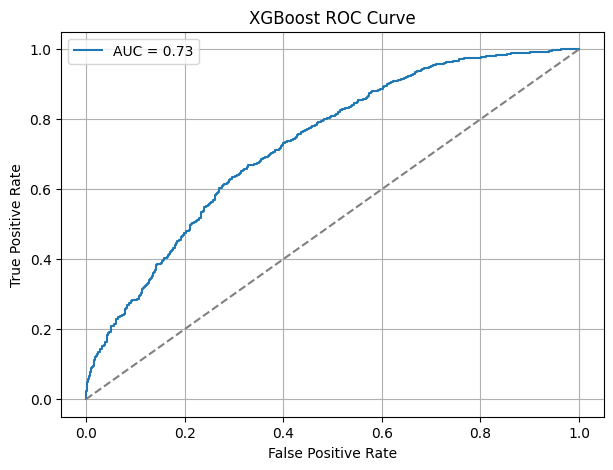

100%|===================| 1999/2000 [00:22<00:00]       <ipython-input-3-1283474344>:148: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, show=False)


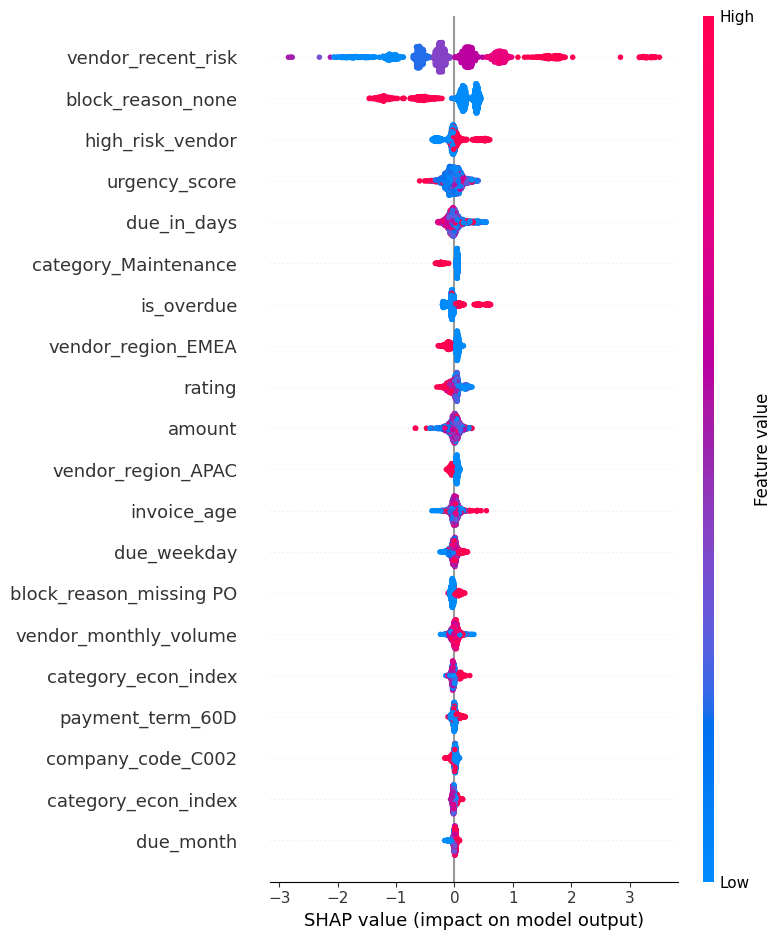

In [3]:

# 1. SAP-like Data Simulation (10,000 rows)
np.random.seed(42)
random.seed(42)

vendor_ids = ['A001', 'A002', 'A003', 'A004', 'A005']
categories = ['IT', 'Office Supplies', 'Maintenance', 'Catering', 'Logistics']
ratings = [1, 2, 3, 4, 5]
regions = ['EMEA', 'AMER', 'APAC']
gl_codes = ['400100', '400200', '400300']
company_codes = ['C001', 'C002', 'C003']
payment_terms = ['30D', '45D', '60D']
block_reasons = ['none', 'price mismatch', 'missing PO', 'approval delay']

n = 10000
today = pd.to_datetime("today")
data = []

for i in range(n):
    vendor_id = random.choice(vendor_ids)
    amount = np.random.randint(100, 5000)
    due_in_days = np.random.randint(-10, 31)
    category = random.choice(categories)
    rating = random.choice(ratings)
    company_code = random.choice(company_codes)
    gl_code = random.choice(gl_codes)
    vendor_region = random.choice(regions)
    payment_term = random.choice(payment_terms)
    block_reason = random.choice(block_reasons)

    invoice_date = today - pd.to_timedelta(np.random.randint(1, 90), unit='d')
    due_date = invoice_date + pd.to_timedelta(int(random.choice([30, 45, 60])), unit='d')

    late_prob = 0.2 if due_in_days >= 0 and rating >= 3 and block_reason == 'none' else 0.7
    payment_status = 'late' if np.random.rand() < late_prob else 'on_time'

    data.append([
        i+1, vendor_id, amount, due_in_days, category, rating,
        company_code, gl_code, vendor_region, payment_term, block_reason,
        invoice_date, due_date, payment_status
    ])

columns = ["invoice_id", "vendor_id", "amount", "due_in_days", "category", "rating",
           "company_code", "gl_code", "vendor_region", "payment_term", "block_reason",
           "invoice_date", "due_date", "payment_status"]

df = pd.DataFrame(data, columns=columns)
df["label"] = df["payment_status"].map({"on_time": 0, "late": 1})

# 2. Advanced Feature Engineering
df["is_overdue"] = (df["due_in_days"] < 0).astype(int)
df["urgency_score"] = df["amount"] / (df["due_in_days"].abs() + 1)
df["high_risk_vendor"] = (df["rating"] <= 2).astype(int)
df["invoice_age"] = (today - pd.to_datetime(df["invoice_date"])).dt.days
df["due_weekday"] = pd.to_datetime(df["due_date"]).dt.weekday
df["due_month"] = pd.to_datetime(df["due_date"]).dt.month
df["due_month_end_flag"] = (df["due_month"] % 3 == 0).astype(int)
df["due_quarter"] = pd.to_datetime(df["due_date"]).dt.quarter

df = df.sort_values(['vendor_id', 'invoice_date'])
df["vendor_avg_delay"] = df.groupby('vendor_id')['due_in_days'].transform('mean')
df["vendor_late_rate"] = df.groupby('vendor_id')['label'].transform('mean')
df["vendor_recent_risk"] = df.groupby('vendor_id')['label'].rolling(window=10, min_periods=1).mean().reset_index(level=0, drop=True)

np.random.seed(42)
category_index = df['category'].map({cat: np.random.uniform(0.8, 1.2) for cat in df['category'].unique()})
df['category_econ_index'] = category_index

vendor_discount = {v: np.random.uniform(0, 0.1) for v in df['vendor_id'].unique()}
df['vendor_avg_discount'] = df['vendor_id'].map(vendor_discount)

df['invoice_month'] = pd.to_datetime(df["due_date"]).dt.to_period('M')
df['vendor_monthly_volume'] = df.groupby(['vendor_id', 'invoice_month'])['invoice_id'].transform('count')

# 3. One-hot encoding of categorical variables
df = pd.get_dummies(df, columns=["category", "company_code", "vendor_region", "payment_term", "block_reason"], drop_first=True)

# 4. Final Features list
features = ["amount", "due_in_days", "rating", "is_overdue", "urgency_score", "high_risk_vendor",
            "invoice_age", "due_weekday", "due_month", "due_month_end_flag", "due_quarter",
            "vendor_avg_delay", "vendor_late_rate", "vendor_recent_risk", "category_econ_index",
            "vendor_avg_discount", "vendor_monthly_volume"] + \
           [col for col in df.columns if col.startswith(("category_", "company_code_", "vendor_region_", "payment_term_", "block_reason_"))]

X = df[features]
y = df["label"]

# 5. Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 6. Optimized XGBoost Pipeline with SMOTE
xgb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=1.0,
        scale_pos_weight=1.5,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42))
])

# 7. Manual Cross-validation with .values conversion
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb_pipeline.fit(X_tr.values, y_tr.values)
    y_val_proba = xgb_pipeline.predict_proba(X_val.values)[:, 1]
    auc_scores.append(roc_auc_score(y_val, y_val_proba))

print(f"CV AUC scores: {auc_scores}")
print(f"Mean CV AUC: {np.mean(auc_scores):.3f}")

# 8. Final training on full training set
xgb_pipeline.fit(X_train.values, y_train.values)

# 9. Evaluation on test set
y_pred = xgb_pipeline.predict(X_test.values)
y_proba = xgb_pipeline.predict_proba(X_test.values)[:, 1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.3f}")

# 10. ROC Curve plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# 11. SHAP explainability plots
shap.initjs()
explainer = shap.Explainer(xgb_pipeline.named_steps['xgb'], X_test.astype("float64"))
shap_values = explainer(X_test.astype("float64"))
shap.summary_plot(shap_values, X_test, show=False)
plt.show()


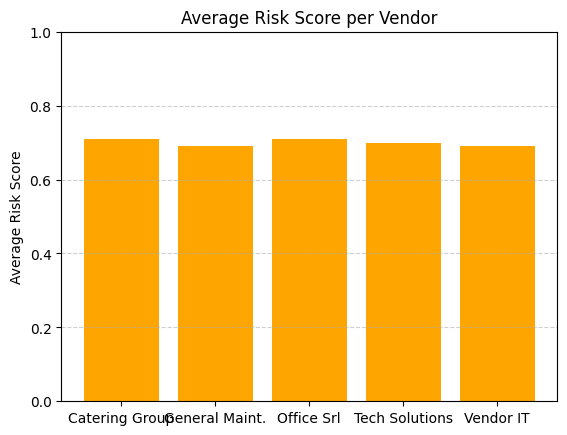

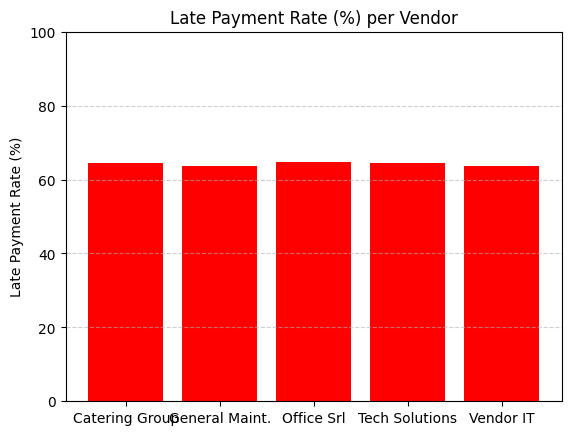

In [4]:
# 12. Alert system + KPI calculation
df["risk_score"] = xgb_pipeline.predict_proba(df[features].values)[:, 1]
vendor_map = {"A001": "Vendor IT", "A002": "Office Srl", "A003": "General Maint.",
              "A004": "Tech Solutions", "A005": "Catering Group"}
df["vendor_name"] = df["vendor_id"].map(vendor_map)

alert_df = df[df["risk_score"] > 0.75][["invoice_id", "vendor_name", "risk_score"]].copy()
alert_df["priority_action"] = np.where(alert_df["risk_score"] > 0.85, "Immediate follow-up", "Monitor")

kpi_df = df.groupby("vendor_name").agg({
    "due_in_days": "mean",
    "label": "mean",
    "amount": "sum",
    "risk_score": "mean"
}).reset_index()
kpi_df.columns = ["vendor_name", "avg_due_days", "late_payment_rate", "total_amount", "avg_risk_score"]
kpi_df["late_payment_rate"] = (kpi_df["late_payment_rate"] * 100).round(2)
kpi_df[["avg_due_days", "total_amount", "avg_risk_score"]] = kpi_df[["avg_due_days", "total_amount", "avg_risk_score"]].round(2)

# 13. KPI Visualization in Python
plt.bar(kpi_df["vendor_name"], kpi_df["avg_risk_score"], color="orange")
plt.title("Average Risk Score per Vendor")
plt.ylabel("Average Risk Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

plt.bar(kpi_df["vendor_name"], kpi_df["late_payment_rate"], color="red")
plt.title("Late Payment Rate (%) per Vendor")
plt.ylabel("Late Payment Rate (%)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# 14. Export CSVs for Power BI
df.to_csv("invoices_enhanced.csv", index=False)
alert_df.to_csv("invoice_alerts.csv", index=False)
kpi_df.to_csv("invoice_dashboard_data.csv", index=False)